<a href="https://colab.research.google.com/github/krishnamanc/PytorchPractice/blob/main/transfer_learning_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [20]:
!pip install torchsummary

In [2]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

--2024-06-12 04:01:29--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.238.109.25, 18.238.109.122, 18.238.109.16, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.238.109.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   253MB/s    in 0.2s    

2024-06-12 04:01:29 (253 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [3]:
!unzip hymenoptera_data.zip

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_data/train/ants/147318

Transfer Learning for Computer Vision Tutorial
==============================================

**Author**: [Sasank Chilamkurthy](https://chsasank.github.io)

In this tutorial, you will learn how to train a convolutional neural
network for image classification using transfer learning. You can read
more about the transfer learning at [cs231n
notes](https://cs231n.github.io/transfer-learning/)

Quoting these notes,

> In practice, very few people train an entire Convolutional Network
> from scratch (with random initialization), because it is relatively
> rare to have a dataset of sufficient size. Instead, it is common to
> pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
> contains 1.2 million images with 1000 categories), and then use the
> ConvNet either as an initialization or a fixed feature extractor for
> the task of interest.

These two major transfer learning scenarios look as follows:

-   **Finetuning the ConvNet**: Instead of random initialization, we
    initialize the network with a pretrained network, like the one that
    is trained on imagenet 1000 dataset. Rest of the training looks as
    usual.
-   **ConvNet as fixed feature extractor**: Here, we will freeze the
    weights for all of the network except that of the final fully
    connected layer. This last fully connected layer is replaced with a
    new one with random weights and only this layer is trained.


In [4]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [21]:
from torchsummary import summary

Load Data
=========

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we\'re going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants
and bees. There are 75 validation images for each class. Usually, this
is a very small dataset to generalize upon, if trained from scratch.
Since we are using transfer learning, we should be able to generalize
reasonably well.

This dataset is a very small subset of imagenet.


In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Visualize a few images
======================

Let\'s visualize a few training images so as to understand the data
augmentations.


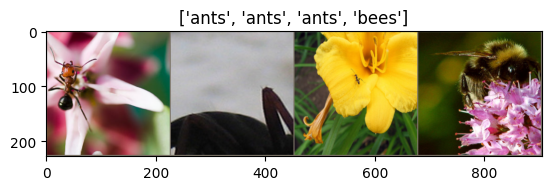

In [7]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
==================

Now, let\'s write a general function to train a model. Here, we will
illustrate:

-   Scheduling the learning rate
-   Saving the best model

In the following, parameter `scheduler` is an LR scheduler object from
`torch.optim.lr_scheduler`.


In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

Visualizing the model predictions
=================================

Generic function to display predictions for a few images


In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the ConvNet
======================

Load a pretrained model and reset final fully connected layer.


In [18]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
==================

It should take around 15-25 min on CPU. On GPU though, it takes less
than a minute.


In [15]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)

Epoch 0/49
----------
train Loss: 0.3431 Acc: 0.8689
val Loss: 0.1137 Acc: 0.9673

Epoch 1/49
----------
train Loss: 0.3159 Acc: 0.8484
val Loss: 0.1211 Acc: 0.9281

Epoch 2/49
----------
train Loss: 0.2966 Acc: 0.8607
val Loss: 0.1216 Acc: 0.9542

Epoch 3/49
----------
train Loss: 0.2625 Acc: 0.9098
val Loss: 0.1287 Acc: 0.9542

Epoch 4/49
----------
train Loss: 0.2549 Acc: 0.8852
val Loss: 0.1280 Acc: 0.9216

Epoch 5/49
----------
train Loss: 0.2528 Acc: 0.8648
val Loss: 0.1144 Acc: 0.9412

Epoch 6/49
----------
train Loss: 0.3086 Acc: 0.8730
val Loss: 0.1318 Acc: 0.9281

Epoch 7/49
----------
train Loss: 0.2384 Acc: 0.9098
val Loss: 0.1114 Acc: 0.9542

Epoch 8/49
----------
train Loss: 0.3126 Acc: 0.8525
val Loss: 0.1155 Acc: 0.9608

Epoch 9/49
----------
train Loss: 0.2958 Acc: 0.8852
val Loss: 0.1150 Acc: 0.9477

Epoch 10/49
----------
train Loss: 0.2062 Acc: 0.9262
val Loss: 0.1188 Acc: 0.9542

Epoch 11/49
----------
train Loss: 0.2109 Acc: 0.9344
val Loss: 0.1241 Acc: 0.9281

Ep

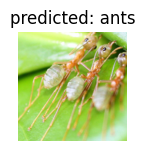

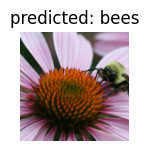

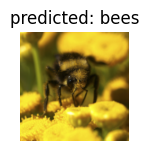

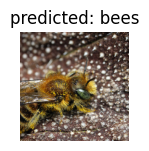

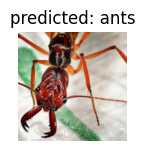

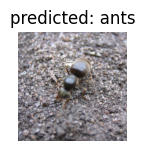

In [14]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
==================================

Here, we need to freeze all the network except the final layer. We need
to set `requires_grad = False` to freeze the parameters so that the
gradients are not computed in `backward()`.

You can read more about this in the documentation
[here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward).


In [23]:
model_conv = torchvision.models.mobilenet_v3_large(weights='MobileNet_V3_Large_Weights.DEFAULT')

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 143MB/s]


In [26]:
device

device(type='cuda', index=0)

In [25]:
model_conv.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [27]:
summary(model_conv, input_size=(3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 16, 112, 112]             144
       BatchNorm2d-5         [-1, 16, 112, 112]              32
              ReLU-6         [-1, 16, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             256
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 64, 112, 112]           1,024
      BatchNorm2d-11         [-1, 64, 112, 112]             128
             ReLU-12         [-1, 64, 112, 112]               0
           Conv2d-13           [-1, 64, 56, 56]             576
      BatchNorm2d-14           [-1, 64,

In [28]:
for param in model_conv.parameters():
    param.requires_grad = False

In [29]:
# Replace the final classification layer with a new linear layer with 2 output features
model_conv.classifier[3] = nn.Linear(in_features=model_conv.classifier[3].in_features, out_features=2)

In [31]:
model_conv.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [32]:
summary(model_conv, input_size=(3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 16, 112, 112]             144
       BatchNorm2d-5         [-1, 16, 112, 112]              32
              ReLU-6         [-1, 16, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             256
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 64, 112, 112]           1,024
      BatchNorm2d-11         [-1, 64, 112, 112]             128
             ReLU-12         [-1, 64, 112, 112]               0
           Conv2d-13           [-1, 64, 56, 56]             576
      BatchNorm2d-14           [-1, 64,

In [34]:
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
==================

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don\'t need to be computed for most of the
network. However, forward does need to be computed.


In [36]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4175 Acc: 0.8197
val Loss: 0.2988 Acc: 0.9477

Epoch 1/24
----------
train Loss: 0.3974 Acc: 0.8484
val Loss: 0.3084 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.3949 Acc: 0.8238
val Loss: 0.3127 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.4044 Acc: 0.8156
val Loss: 0.3185 Acc: 0.9020

Epoch 4/24
----------
train Loss: 0.4108 Acc: 0.8402
val Loss: 0.3208 Acc: 0.9020

Epoch 5/24
----------
train Loss: 0.3884 Acc: 0.8443
val Loss: 0.3176 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.4374 Acc: 0.7992
val Loss: 0.3208 Acc: 0.9085

Epoch 7/24
----------
train Loss: 0.4107 Acc: 0.8361
val Loss: 0.3205 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.4572 Acc: 0.7787
val Loss: 0.3186 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.4125 Acc: 0.8279
val Loss: 0.3214 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.4199 Acc: 0.8443
val Loss: 0.3222 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.4077 Acc: 0.8320
val Loss: 0.3216 Acc: 0.9085

Ep

KeyboardInterrupt: 

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

Inference on custom images
==========================

Use the trained model to make predictions on custom images and visualize
the predicted class labels along with the images.


In [ ]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

In [ ]:
visualize_model_predictions(
    model_conv,
    img_path='data/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()

Further Learning
================

If you would like to learn more about the applications of transfer
learning, checkout our [Quantized Transfer Learning for Computer Vision
Tutorial](https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html).
